### Imports and parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import networkx as nx
%matplotlib notebook

In [2]:
file = "inputs/2022-11-23-12_13_44.csv"

In [3]:
df = pd.read_csv(file)
df.head()

,FRAME,KEY,STATUS
0,143,Key.enter,DOWN
1,145,Key.enter,UP
2,243,Key.enter,DOWN
3,246,Key.enter,UP
4,346,Key.right,DOWN


### Only keep keys that are of our interest

In [4]:
df_trim = df[(df['KEY'] == 'Key.left') | (df['KEY'] == 'Key.right') | (df['KEY'] == '\'d\'')]

df_trim.loc[(df_trim['KEY'] == 'Key.right') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'R'
df_trim.loc[(df_trim['KEY'] == 'Key.right') & (df_trim['STATUS'] == 'UP'), 'action'] = 'r'

df_trim.loc[(df_trim['KEY'] == 'Key.left') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'L'
df_trim.loc[(df_trim['KEY'] == 'Key.left') & (df_trim['STATUS'] == 'UP'), 'action'] = 'l'

df_trim.loc[(df_trim['KEY'] == '\'d\'') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'J'
df_trim.loc[(df_trim['KEY'] == '\'d\'') & (df_trim['STATUS'] == 'UP'), 'action'] = 'j'

/tmp/ipykernel_650/1644764957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim.loc[(df_trim['KEY'] == 'Key.right') & (df_trim['STATUS'] == 'DOWN'), 'action'] = 'R'


In [5]:
df_trim = df_trim[["FRAME", "action"]].reset_index(drop=True)
df_trim.head()

,FRAME,action
0,346,R
1,491,J
2,517,j
3,519,r
4,534,L


### Extract timeline

In [6]:
start = df_trim.FRAME.min()

# r, j, l
data = {"R": [], "L": [], "J": []}
r=0
l=0
j=0
for index, row in df_trim.iterrows():
    if row.action == "R".upper():
        data["R"].append([row.FRAME])
    if row.action == "R".lower():
        data["R"][-1].append(row.FRAME - data["R"][-1][0])
        
    if row.action == "L".upper():
        data["L"].append([row.FRAME])
    if row.action == "L".lower():
        data["L"][-1].append(row.FRAME - data["L"][-1][0])
        
    if row.action == "J".upper():
        data["J"].append([row.FRAME])
    if row.action == "J".lower():
        data["J"][-1].append(row.FRAME - data["J"][-1][0])

<IPython.core.display.Javascript object>


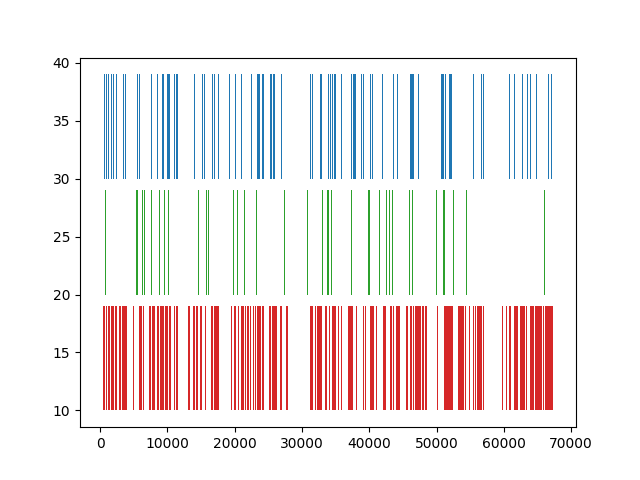

In [7]:
fig, ax = plt.subplots()
ax.broken_barh(data["R"], (10, 9), facecolors='tab:red')
ax.broken_barh(data["L"], (20, 9), facecolors='tab:green')
ax.broken_barh(data["J"], (30, 9), facecolors='tab:blue')
plt.show()

### Extract patterns

In [8]:
all_keys = ''.join(list(df_trim["action"]))
all_keys

'RJjrLlRJjrLlRJjrJLjJRljLrlLlRJjrLJjlRJjJjJjJjrLlRrLlRJjJjJjJjJjJjJjJjrLJjlRJjJjJjrRJjrLlRJjrLlLJjlRJjJjJjJjrRJjrRJjrRJjrJRjrRJjJjJjJjJjJjJjJjJjJjJjrRJjJjrRJjrRrRrRrRJjrLlJRjJjJjJjrLJjJjRlJjJjrRJjrRJjJjJjJjJjJjJjrLlLlRJjrRJjJjrLlRJjrRrLlRrRJjJjrRrRJjJjrLJlRjrRJjrLlRJjrLJjJjJjlRJjLrlJRjJjJjJjJjJjJjrLlRrLJljRrLlJjRrRrLRlJrLjlRJjJjrRrLlLlRrRJjrJRjrRrRrRrJRjJjJjJjJjrLlRJjrRJjrRJjJjrRLrlRJjrLlJjRJjJjJjJjrJLjlRrLlRJrLljRJjJjJjrJRjrRJjJjrRJjJjrLJjlJLjlLlRrJjRJrjRJrjJRjJjJjJjJjJjrLlRrLlRrRrRJjrRrRrRrRJjrRJjrLlJjLlLlJjRrJjLJjlJjRJjJjJjJjJjJjrJRjJjrRJjJjJjrLlLJjlRrRrRJjrLlRrRrRrLlJjRrRrRrJjRrJjLJljLlRrLJjlRrLlRJrjJRrjLlLlRrRJjJrjLlJLjlJjRrLlRrJRjrLlRJrjLlLlJjJjRJjJjrLlRJjJjrRrJjRrRrRJjJjJjJjrLlRJjJjJjrRJjrRJjJjrRrRrRrRrRrJjJjRrJjRrJjRrJjRrJjRrRrLlRrLJljLlRrRrRrLlRJjJjJrRjJjJjJjrJjRJjJjJjrLJjlJjRrLJljRJjrRJjJjJjJjrJjJRjrJRjJjJjrLRlrLRlrRJrjRJjrRJjrRrJjJjRrJjRrJjJjRJjJjrRJjrRrRrRrJjRrJjRJjrRJjJjrLlRrRJrjRrJRjrRrRJjJjJjJjrRrRJjJjJjJjJjrRJjJjrJjRrLlRrJRjrLlRJjJjJjLrRlrLlLlRJjrRJjJjJjrRrLlLlRJjJjrLlL

In [9]:
def getAllSubStrings(x, l=None, freq=False):
    if l == None:
        l = len(x)
    
    allSubStrings = [x[i:i+l] for i in range(0, len(x)) if len(x[i:i+l]) == l]

    if freq:
        return allSubStrings
    else:
        return set(allSubStrings)

In [10]:
def extract_freq(x, l=3, sort='value'):
    res = {}
    substrings = getAllSubStrings(all_keys, l=l, freq=True)
    for idx in substrings:
        if idx not in res.keys():
            res[idx] = 1
        else:
            res[idx] += 1
    if sort == 'key':
        return dict(sorted(res.items(), key=lambda item: item[0], reverse=False))
    elif sort == 'value':
        return dict(sorted(res.items(), key=lambda item: item[1], reverse=True))

In [11]:
all_patterns = {}
for i in range(4, 11):
    all_patterns.update(extract_freq(all_keys, l=i, sort='value'))
all_patterns = dict(sorted(all_patterns.items(), key=lambda item: item[1], reverse=True))
all_patterns

{'JjJj': 193,
 'jJjJ': 117,
 'jJjJj': 110,
 'JjJjJ': 108,
 'JjJjJj': 101,
 'RJjr': 83,
 'rRJj': 75,
 'jJjr': 70,
 'RJjJ': 69,
 'JjrR': 68,
 'JjJjr': 68,
 'RJjJj': 65,
 'jJjJjJ': 65,
 'JjrL': 64,
 'jJjJjJj': 62,
 'JjJjJjJ': 59,
 'lRJj': 56,
 'JjJjJjJj': 56,
 'jrLl': 52,
 'rLlR': 51,
 'JjrLl': 48,
 'jrRJ': 47,
 'rRrR': 46,
 'LlRJ': 45,
 'RrRr': 43,
 'rRJjr': 43,
 'jrRJj': 42,
 'RrRJ': 39,
 'JjrRJ': 39,
 'LlRJj': 38,
 'RJjrR': 38,
 'jJjJjJjJ': 38,
 'jJjJjr': 37,
 'JjrRJj': 36,
 'RJjJjJ': 35,
 'JjJjJjr': 35,
 'JjJjJjJjJ': 35,
 'jJjJjJjJj': 35,
 'LlLl': 34,
 'RJjrL': 33,
 'jrLlR': 33,
 'rLlRJ': 33,
 'lRJjr': 33,
 'rRJjJ': 32,
 'RrRJj': 32,
 'RJjJjJj': 32,
 'JjJjJjJjJj': 32,
 'jrRr': 31,
 'jJjrL': 31,
 'JjJjrL': 31,
 'rRJjJj': 31,
 'LlRr': 30,
 'JjRr': 30,
 'jJjrR': 30,
 'RJjJjr': 30,
 'RrRrR': 29,
 'JjrLlR': 29,
 'RrJj': 28,
 'JjrRr': 28,
 'JjJjrR': 28,
 'RrLl': 27,
 'rLlRJj': 27,
 'RJjrLl': 26,
 'LJjl': 25,
 'rJjR': 25,
 'RJrj': 24,
 'jrLlRJ': 24,
 'LlRJjr': 24,
 'jrRJjr': 24,
 'JjlR': 23,

### First 10 patterns

[('JjJj', 193), ('jJjJ', 117), ('jJjJj', 110), ('JjJjJ', 108), ('JjJjJj', 101), ('RJjr', 83), ('rRJj', 75), ('jJjr', 70), ('RJjJ', 69), ('JjrR', 68)]


<IPython.core.display.Javascript object>


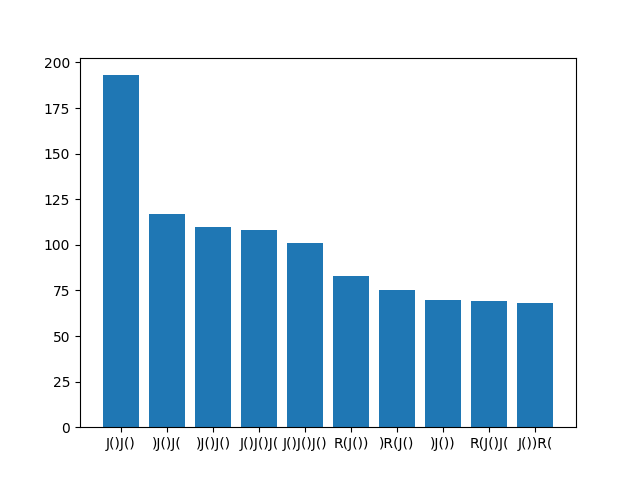

In [12]:
from itertools import islice
n_items = list(islice(all_patterns.items(), 10))
print(n_items)
keys = []
values = []
for i, (k, v) in enumerate(n_items):
    k = k.replace("J", "J(")
    k = k.replace("j", ")")
    k = k.replace("R", "R(")
    k = k.replace("r", ")")
    k = k.replace("L", "L(")
    k = k.replace("l", ")")
    keys.append(k)
    values.append(v)
    
fig, ax = plt.subplots()
ax.bar(keys, values)
plt.show()

### Where are the patterns

In [13]:
place_patterns = {}
for pattern in all_patterns.keys():
    place_patterns[pattern] = []
    for m in re.finditer(f'(?={pattern})', all_keys):
        place_patterns[pattern].append(df_trim.iloc[m.start()].FRAME)
place_patterns

{'JjJj': [1175,
  1220,
  1351,
  1543,
  1597,
  1667,
  1700,
  1754,
  1861,
  1969,
  2276,
  2334,
  2821,
  2855,
  2920,
  3209,
  3238,
  3330,
  3377,
  3412,
  3448,
  3539,
  3640,
  3683,
  3745,
  3884,
  5415,
  5424,
  5511,
  5590,
  5838,
  5871,
  5912,
  5965,
  6011,
  6044,
  6351,
  6668,
  7261,
  7598,
  7608,
  7836,
  7875,
  7924,
  7983,
  8075,
  8554,
  9207,
  9221,
  9236,
  9404,
  9885,
  9930,
  9986,
  10207,
  10288,
  10458,
  11005,
  11334,
  11357,
  11398,
  11427,
  13775,
  13821,
  13850,
  13886,
  13957,
  14217,
  14360,
  16448,
  16565,
  16690,
  16944,
  17055,
  17070,
  17300,
  17337,
  17560,
  19159,
  19893,
  20040,
  20091,
  20320,
  20333,
  20729,
  20749,
  20761,
  21088,
  22126,
  22356,
  22548,
  23083,
  23494,
  23557,
  23655,
  24058,
  24152,
  24203,
  24249,
  25300,
  25735,
  25813,
  26189,
  26226,
  26879,
  27714,
  31245,
  31330,
  31416,
  32733,
  32786,
  32860,
  33513,
  33884,
  34452,
  34471,
  

### Example: finding the "double jump" pattern

<IPython.core.display.Javascript object>


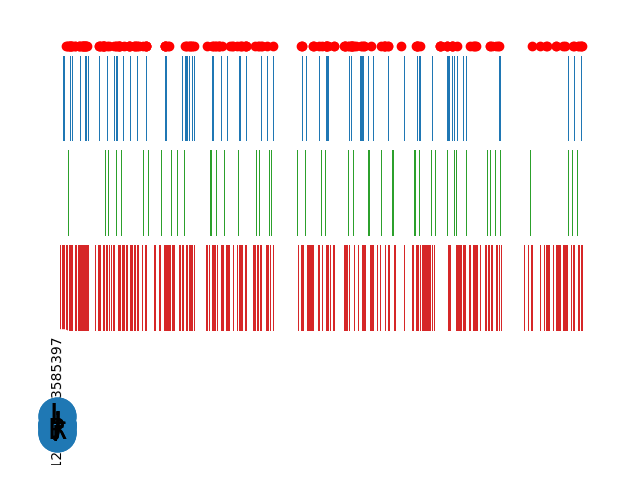

In [14]:
fig, ax = plt.subplots()
ax.broken_barh(data["R"], (10, 9), facecolors='tab:red')
ax.broken_barh(data["L"], (20, 9), facecolors='tab:green')
ax.broken_barh(data["J"], (30, 9), facecolors='tab:blue')
ax.scatter(place_patterns["JjJj"], len(place_patterns["JjJj"]) * [40], c='red')
plt.show()

### Markov

In [38]:
states_simple = ["Jump", "Left", "Right"]
states_complete = {"R": "Right pressed", "r": "Right released", "L": "Left pressed", "l": "Left released", "J": "Jump pressed", "j": "Jump release"}

In [31]:
probs_complete = {}

# Find probabilities
for i, k in enumerate(all_keys):
    try:
        next_k = all_keys[i+1]
    except IndexError:
        continue
        
    # Complete
    if k not in probs_complete:
        probs_complete[k] = {}
        
    if next_k not in probs_complete[k]:
        probs_complete[k][next_k] = 0
        
    probs_complete[k][next_k] += 1
        
for key, v in probs_complete.items():
    for next_key, _ in v.items():
        probs_complete[key][next_key] /= len(all_keys) - 1
        
probs_complete

{'R': {'J': 0.08083441981747067,
  'l': 0.004345936549326379,
  'r': 0.07214254671881791,
  'j': 0.013472403302911778,
  'L': 0.000434593654932638},
 'J': {'j': 0.19643633202955238,
  'L': 0.009561060408518035,
  'R': 0.015210777922642329,
  'l': 0.0021729682746631897,
  'r': 0.016079965232507605},
 'j': {'r': 0.07692307692307693,
  'J': 0.09734897870491091,
  'L': 0.009995654063450673,
  'l': 0.02216427640156454,
  'R': 0.03302911777488049},
 'r': {'L': 0.049109083007388095,
  'J': 0.030856149500217298,
  'l': 0.002607561929595828,
  'R': 0.07214254671881791,
  'j': 0.016079965232507605},
 'L': {'l': 0.05823554976097349,
  'j': 0.009126466753585397,
  'r': 0.004345936549326379,
  'J': 0.016079965232507605,
  'R': 0.001738374619730552},
 'l': {'R': 0.048674489352455455,
  'j': 0.004345936549326379,
  'L': 0.020425901781833986,
  'J': 0.014341590612777053,
  'r': 0.001738374619730552}}

In [40]:
G = nx.DiGraph()
for k, v in probs_complete.items():
    for next_k, v2 in v.items():
        G.add_edge(k, next_k, weight=round(v2, 2))
G = nx.relabel_nodes(G, states_complete)

<IPython.core.display.Javascript object>


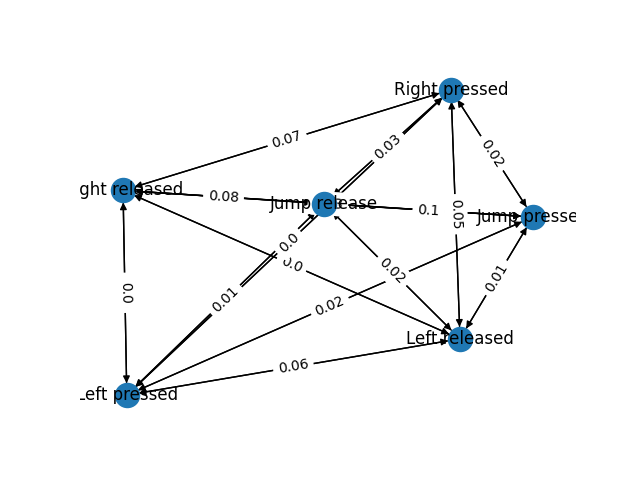

In [41]:
fig, ax = plt.subplots()
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, ax=ax)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

ax.set_axis_off()
plt.show()